# Introduction to the likelihood

When we are fitting the parameters $\alpha$ in some model $\mathcal{M}(x;\alpha)$ to some data $\mathcal{D} = \{x_i , y_i\}$, how do we judge how well a given model prediction $\{ x_i , y_m(x_i;\alpha) \equiv \mathcal{M}(x_i;\alpha) \} $ describes our data $\mathcal{D}$?

We have to come up with a model for the *likelihood*. This is the conditional probability that our data $\mathcal{D}$ (also called evidence) is described by a given model prediction $y_m(x_i;\alpha)$. We can write it as $p(\mathcal{D} | y_m(x_i;\alpha))$ or $p(\mathcal{D} | \mathcal{M}, \alpha)$. Sometimes we use $\mathcal{L}$ instead of $p$ to write the likelihood, but it is just a conditional probability. It tells you the probability, given model $\mathcal{M}$, with a fixed set of parameters $\alpha$, that some data $\mathcal{D} = \{ x_i,y_i \}$ is the result.

Every method for fitting or calibrating a model (whether it is explicitly stated or not) makes some assumption about the likelihood.

How do we come up with a *defensible* form for the likelihood for a given set of evidence and a given model? 

## A very simple likelihood model 

What if there are no errors in our model or in $\{ x_i, y_i\}$ at all? Then our model must exactly reproduce $y_i$, and our lileihood is:

\begin{equation}
p(\{ x_i,y_i \} | y_m(x_i;\alpha) ) = \begin{cases} 1 & y_m(x_i;\alpha) = y_i \\ 0 & \rm{otherwise} \end{cases}
\end{equation}

Can you guess what issues this might have?

## The general case

In real cases, our evidence $\mathcal{D}$ is more than just a set of numbers $\{x_i , y_i\}$. It is, in fact, a probability distribution itself: $\mathcal{D} \equiv p( \vec{x}, \vec{y} )$; a given $\{x,y\}$ pair is a measurement of a random variable. Based on the uncertainty information provided by the experimentalists, and the limitations in our model, we must come up with a reasonable model for what $p( \vec{x}, \vec{y} )$ is, and use it to construct a likelihood. 

Then, when we do a frequentist model fit, we are searching through $\alpha$-space trying to find the $\alpha$ that corresponds to $\text{max} \left[ p(\mathcal{D}| \mathcal{M},\alpha) \right]$. This is called [Maximum Likelihood Estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 

As we shall see, minimizing the $\chi^2$ is just a special case of MLE, subject to certain assumptions (which may not always be appropriate!).

When we do a Bayesian calibration, we sample $\alpha$-space in such a way that the samples converge on a distribution that is related to the likelihood, called the posterior $p(\alpha | \mathcal{D}, \mathcal{M})$, which just modifies the likelihood to include prior belief about $\alpha$: 

\begin{equation}
p(\alpha | \mathcal{D}, \mathcal{M}) \propto p(\mathcal{D}| \mathcal{M},\alpha) p(\alpha).
\end{equation}

This is just the result of Bayes theorem. In Bayesian calibration as well, one often sees the likelihood $p(\mathcal{D}| \mathcal{M},\alpha)$ modeled as $\exp(-\chi^2)$. Again, this may not always be appropriate! 

## Under what assumptions is a $\chi^2$-distribution appropriate for the likelihood?

Let us *assume* there is some ground truth $\{x_i, y_i^\rm{true}\}$, and futhermore assume that our model, for some unknown true parameters, is able to exactly replicate the truth:

\begin{equation}
M(x_i;\alpha^\rm{true}) =  y_i^\rm{true}
\end{equation}

This may be a big assumption, and, in realistic scenarios, one may want to to instead use 

\begin{equation}
M(x_i;\alpha^\rm{true}) =  y_i^\rm{true} + \epsilon_i
\end{equation}

Where $\epsilon_i$ is another random variable describing the model error. We will ignore this for now.

Now we need more assumptions: the measured values $\vec{x}, \vec{y}$ are random vectors from some multivariate probability distribution $p(\vec{x},\vec{y})$.

Let's assume:
- there is no error in $x$; $x_i = x_i^\rm{true}$
- each $y_i$ is really a number of counts in the bin $x_i = \left[ x_{i0} , x_{if} \right]$
- each count is independent of all the others (this is akin to saying there is no systematic error; later in the demo we will see a case for which this assumption is disastrous!)


If there are $N$ total counts, then $p_i = y_i^\rm{true}/N$ is the probability of a count being in bin $i$, and $ 1 - p_i$ is the probability of not being in bin $i$.  Our model prediction is for the probability of a single count being in bin $i$ is just $y_m(x_i;\alpha) / N$. The probability of getting exactly $y$ counts in bin $i$ in $N$ trials is a binomial distribution:

\begin{equation}
p(y_i | N, p_i ) = B(N,p_i) \equiv  \binom{N}{y_i} p_i^{y_i} (1-p_i)^{N-y_i} 
\end{equation}

Plugging in our model prediction for $p_i$, we have the likelihood 

\begin{equation}
p(y_i | N, p_i = \mathcal{M}(x_i;\alpha)/N ) = B(N,\mathcal{M}(x_i;\alpha)/N) \equiv  \binom{N}{y_i} \left( \frac{y_m(x_i;\alpha)}{N} \right)^{y_i} \left( 1- \frac{y_m(x_i;\alpha)}{ N} \right)^{N-y_i} 
\end{equation}

The total liklelihood is the product of this probability for every bin:

\begin{equation}
p( \mathcal{D} | N, \mathcal{M} , \alpha)) =  \prod_i B(N,\mathcal{M}(x_i;\alpha)/N) \equiv \prod_i \binom{N}{y_i} \left( \frac{y_m(x_i;\alpha)}{N} \right)^{y_i} \left( 1- \frac{y_m(x_i;\alpha)}{ N} \right)^{N-y_i} 
\end{equation}

As long as $N$ is known exactly (it's own can of worms), then this is exactly what we are looking for! In principle, one could exactly use this formula in this situation.


How do we get the $\chi^2$ form? Well, when $N \rightarrow \infty$ and $p_i^\rm{true} \rightarrow 0$ such that $N p_i^\rm{true} = y_i^\rm{true}$ stays constant, the binomial distribution limits to a Poission distribution, with mean $y_i^{\rm{true}}$ and standard deviation $\sigma_i = \sqrt{y_i^{\rm{true}}}$:

\begin{equation}
p( \mathcal{D} | N, \mathcal{M} , \alpha) \rightarrow \prod_i \frac{ (y_i^{\rm{true}})^y }{ y\! } e^{-y_i^{\rm{true}}}
\end{equation}

Then using the Central Limit Theorem, we find in the limit as $N \rightarrow \infty$ and $0 < p_i < 1$ fixed, that our Poisson distribution becomes a normal distribution:

\begin{align}
p( \mathcal{D} | N, \mathcal{M} , \alpha) &\rightarrow \prod_i \frac{1}{\sqrt{2 \pi y_i^{\rm{true}}}} \exp{ - \frac{\left( y_i - y_i^{\rm{true}}\right)^2}{ 2 y_i^{\rm{true}}} }
\end{align}

Plugging in $y_m(x_i;\alpha)$ for $y_i^\rm{true}$ and $\sigma_i$ for the standard deviation, we have:

\begin{equation}
p( \mathcal{D} | N, \mathcal{M} , \alpha) = \prod_i \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp{ \left( \frac{(y_i - y_m(x_i;\alpha))^2}{2 \sigma_i^2} \right)}
\end{equation}

Take the log of this function, one of the terms will be of the  $\chi^2$ form:


\begin{equation}
\log p( \mathcal{D} | N, \mathcal{M} , \alpha) \propto -\frac{1}{2} \sum_i  \frac{(y_i - y_m(x_i;\alpha))^2}{\sigma_i^2} + \dots \equiv \chi^2 + \dots 
\end{equation}


It is a useful excercise to take this log and see what the other terms are exactly. In some likelihood models, where the covariance is not known a priori but has parameters that are fit along side the physical model, these other terms will also play a role.

If you've taken a stats course, you've probably done these two limits (Binomial to Poission and Poission to Normal) at some point or another. A nice pedagogical source for the derivations is [The Knolly Bible, Ch. 3](https://indico-tdli.sjtu.edu.cn/event/171/contributions/2123/attachments/982/1592/Knoll4thEdition.pdf). Also, I would like to mention that chatgpt was also useful in preparing this discussion.


## too long; didn't read:

The main point I want to get across is is that we had to make many assumptions to get our likeliood to look like a $\chi^2$! These assumptions are not valid in every case. Whether you are doing Bayesian calibration or frequentist model fitting, whether or not you're even doing uncertainty quantification (which you should be doing), or you just care about finding the "best" parameters, it is your job to come up with a *likelihood model*. That is, a model for the function $p(\{x_i,y_i\}| \mathcal{M},\alpha)$.  You must carefully consider the data and its errors, as well as your physics model and its errors, to come up with such a model. You must also think carefully about the implications of any simplifying assumptions you make (e.g. ignoring systematic error), and transparently disclose them.

## In this demo: the multivariate normal liklelihood model 

In this demo, we will introduce some systematic error. That is, instead of measuring the number of counts in a bin, $y_i$ will instead be some derived quantity like a cross section, which includes some normalization. In particular, we will consider a scenario where this normalization is not known exactly.

This will break the assumption from above that each $y_i$ is indepent from each other. If the limiting conditions leading to a normal distribution are still valid, but there is some covariance between $y_i$'s for different points $x_i$, one can write the likelihood more generally as:

\begin{equation}
p( \mathcal{D} | N, \mathcal{M} , \alpha) = \frac{1}{\sqrt{2 \pi |\mathbf{\Sigma}|}} \exp{ -\left( \vec{\Delta}^T \cdot \mathbf{\Sigma}^{-1} \cdot \vec{\Delta} \right)},
\end{equation}

where $\Delta \equiv (y_i - y_m(x_i;\alpha))$. Then, one must find a model for the covariance matrix $\mathbf{\Sigma}$. If $\mathbf{\Sigma}$ is diagonal, this will resemble the $\exp{\left( -\chi^2 \right)}$ form. The demo will begin with this assmumption, and test out different models for the covariance matrix $\mathbf{\Sigma}$.

In fact, one can show that this is a very good assumption for many cases due to the Central Limit Theorem, as any bounded, finite-variance distribution looks like a normal distribution near the mean. One can think of the generalized $\chi^2 \equiv \vec{\Delta}^T \cdot \mathbf{\Sigma}^{-1} \cdot \vec{\Delta}$ (also called the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)) as the truncation of the Taylor expansion of the log probability of an arbitrary distribution to 2nd order. See [Bayesian Data Analysis by Gelman, Ch. 4](https://sites.stat.columbia.edu/gelman/book/BDA3.pdf). In other words, for cases in which there are many samples and the CLT applies, the above model for the likelihood function as a generalized multivariate normal is often adequate. The job of the modeler is then to come up with a model for $\mathbf{\Sigma}$, given their knowledge of the experimental evidence and the model. This is what we will be doing in the demo.

Some good reading is [D'Agostini, 1994](https://s3.cern.ch/inspire-prod-files-a/af06df9041f5b73dcdf6d1ae8172caa1).

# Comparing likelihood models: there is a right way, and many wrong ways!

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## Plotting functions

In [3]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_sampler.chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_sampler.chain.shape[1]):
        axes[i].plot(walker.model_sampler.chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(
            true_value, 0, len(walker.model_sampler.chain), "r", linestyle="--"
        )

    axes[-1].plot(walker.model_sampler.logp_chain)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")
    axes[-1].set_xlabel(r"$i$")

In [4]:
def plot_posterior_corner(walker, true_params):
    fig = corner.corner(
        walker.model_sampler.chain,
        labels=[p.name for p in my_model.params],
        label="posterior",
        truths=[true_params["m"], true_params["b"]],
    )
    fig.suptitle("posterior")

In [5]:
def plot_predictive_post(walker, model, x, y_exp, y_err, y_true, x_true=None):
    if x_true is None:
        x_true = x
    n_posterior_samples = walker.model_sampler.chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_sampler.chain[i, :]
        y[i, :] = model.y(x, *sample)

    upper, median, lower = np.percentile(y, [5, 50, 95], axis=0)
    plt.errorbar(
        x,
        y_exp,
        y_err,
        color="k",
        marker="o",
        linestyle="none",
        label="experiment",
    )

    plt.plot(x, y_true, "k--", label="truth")
    plt.plot(x, median, "m:", label="posterior median")
    plt.fill_between(
        x,
        lower,
        upper,
        alpha=0.5,
        zorder=2,
        label=r"posterior inner 90$^\text{th}$ pctl",
    )
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")

## make the model

In [6]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def y(self, x, m, b):
        return m * x + b

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

In [7]:
my_model = LinearModel()

In [8]:
rng = np.random.default_rng(16)

## set up prior

In [9]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

In [10]:
prior_mean = OrderedDict(
    [
        ("m", 2),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 2),
        ("b", 2),
    ]
)

In [11]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [12]:
systematic_fractional_err = 0.1
# choose a normalization 1 std deviation below the mean
N = 1 - systematic_fractional_err
noise_fraction = 0.05
x = np.linspace(0.01, 1.0, 15, dtype=float)
y_true = my_model.y(x, *list(true_params.values()))
y_exp = (y_true + rng.normal(scale=noise_fraction * y_true, size=len(x))) * N
y_stat_err = noise_fraction * y_exp * N

Text(0.5, 1.0, 'experimental constraint with bias')

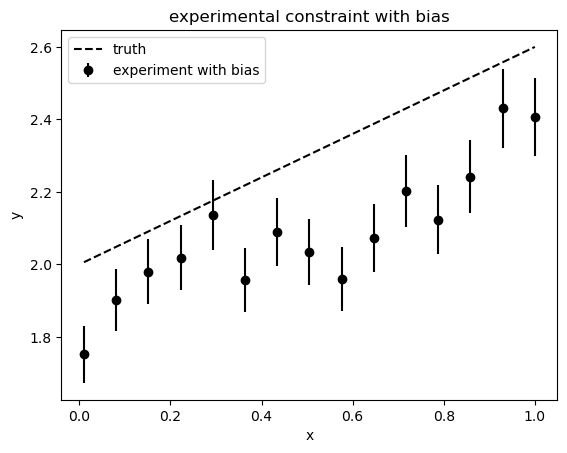

In [13]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

## Compare Likelihood Models
We will look at a few different cases:
1. Covariance is fixed to just statistical error (disregarding systematic error)

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2
   \end{equation}

3. Covariance is just statistical error, but we fit the magnitude of the statistical noise $\eta$ (disregarding systematic error). This means the covariance is not fixed, but will be updated during calibration.

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \eta^2 y_m(x_j; \alpha)^2
   \end{equation}


5. Systematic error is included properly in covariance, making the covariance a function of the model prediction. Again, this means the covariance is not fixed, but will be updated during calibration.

    \begin{equation}
       \Sigma_{ij}(\alpha) = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y_m(x_i; \alpha) y_m(x_j; \alpha)
   \end{equation}

7. Systematic error is included improperly in covariance, using the experimental $y(x_i)$ instead of the model prediction $y_m(x_i;\alpha)$. In this case the covariance is again fixed.

    \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y(x_i) y(x_j)
   \end{equation}


In [14]:
# 1 and 2
obs_stat_only = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
)

# 3
obs_sys_norm_correct = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
    y_sys_err_normalization=systematic_fractional_err,
)

# 4
obs_sys_norm_wrong = rxmc.observation.FixedCovarianceObservation(
    x=x,
    y=y_exp,
    covariance=np.diag(y_stat_err**2)
    + systematic_fractional_err**2 * np.outer(y_exp, y_exp),
)

## set up likelihood models and constraints

In [15]:
# 1 and 3
likelihood = rxmc.likelihood_model.LikelihoodModel()

# 4
likelihood_fixed_cov = rxmc.likelihood_model.FixedCovarianceLikelihood()


# 2 - a special likelihood model that takes in the noise fraction as a parameter
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseFractionErrorModel()

In [16]:
# 1
evidence_stat_only = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood,
        )
    ]
)

# 2
evidence_unknown_stat = rxmc.evidence.Evidence(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
evidence_sys_correct = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct],
            my_model,
            likelihood,
        )
    ]
)

# 4
evidence_sys_wrong = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [17]:
def proposal_distribution_model(x, rng):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 1000, random_state=rng
    )

## Run option 1: fixed covariance, statistical error only

In [18]:
walker1 = rxmc.walker.Walker(
    rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence_stat_only,
    rng=rng,
)

In [19]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.336
CPU times: user 2.97 s, sys: 14.3 ms, total: 2.98 s
Wall time: 2.97 s


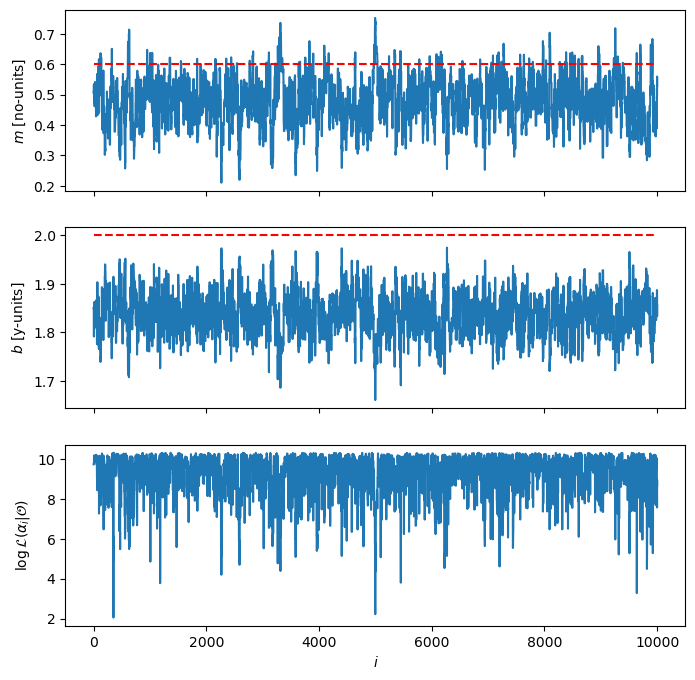

In [20]:
plot_chains(walker=walker1, model=my_model, true_params=true_params)

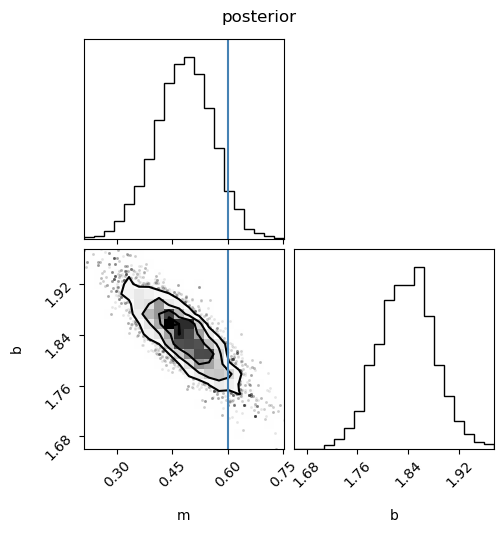

In [21]:
plot_posterior_corner(walker=walker1, true_params=true_params)

Text(0.5, 1.0, 'option 1: fixed statistical error, systematic ignored')

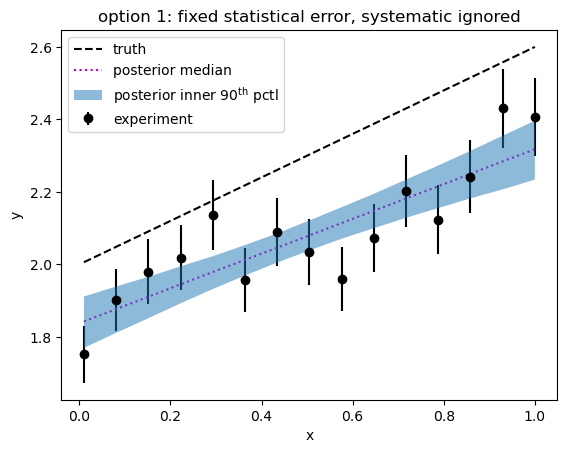

In [22]:
plot_predictive_post(
    walker=walker1, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 1: fixed statistical error, systematic ignored")

## Run option 2: unknown statistical error

We need to come up with a prior for the noise for option 2. We will keep it fairly wide and centered about the reported value.

In [23]:
noise_prior = stats.norm(loc=np.log(noise_fraction), scale=1)

In [24]:
def proposal_distribution_noise(x, rng):
    return np.atleast_1d(stats.norm.rvs(loc=x, scale=0.1, random_state=rng))

In [25]:
walker2 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_unknown_stat,
    likelihood_samplers=[
        rxmc.param_sampling.MetropolisHastingsSampler(
            params=likelihood_unknown_stat.params,
            starting_location=noise_prior.mean(),
            proposal=proposal_distribution_noise,
            prior=noise_prior,
        )
    ],
    rng=rng,
)

In [26]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.350
  Likelihood parameter acceptance fractions: [0.8]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.320
  Likelihood parameter acceptance fractions: [0.78]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.490
  Likelihood parameter acceptance fractions: [0.86]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.260
  Likelihood parameter acceptance fractions: [0.83]
Batch: 5/100 completed, 100 steps. 
  Model parameter acce

In [27]:
def plot_chains_with_err(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_sampler.chain.shape[1] + 3, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_sampler.chain.shape[1]):
        axes[i].plot(walker.model_sampler.chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(
            true_value, 0, len(walker.model_sampler.chain), "r", linestyle="--"
        )

    axes[-3].plot(walker.model_sampler.logp_chain)
    axes[-3].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    lmp = walker.likelihood_samplers[0].params[0]
    axes[-2].plot(walker.likelihood_samplers[0].chain)
    axes[-2].set_ylabel(f"${lmp.latex_name}$ [{lmp.unit}]")
    axes[-2].hlines(
        np.log(noise_fraction),
        0,
        len(walker.likelihood_samplers[0].chain),
        "r",
        linestyle="--",
    )

    axes[-1].plot(walker.likelihood_samplers[0].logp_chain)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

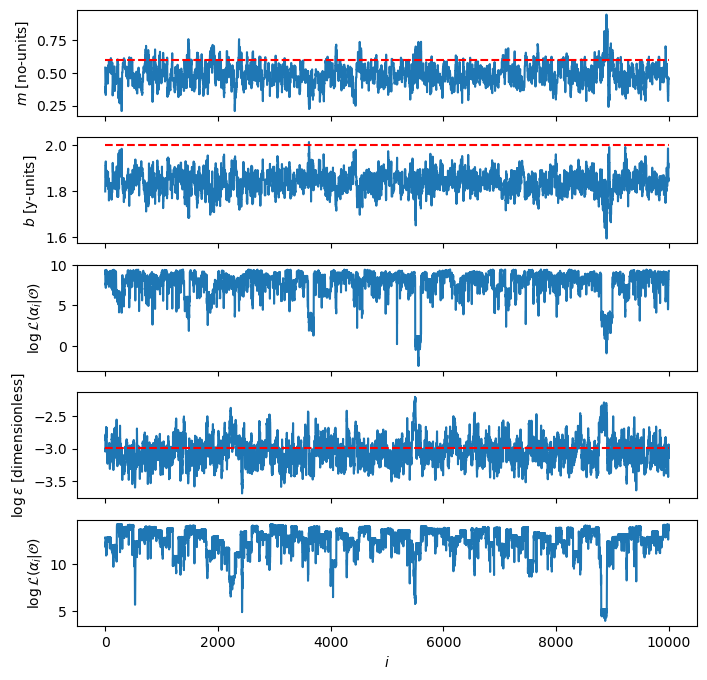

In [28]:
plot_chains_with_err(walker2, my_model, true_params)

Text(0.5, 0.98, 'posterior')

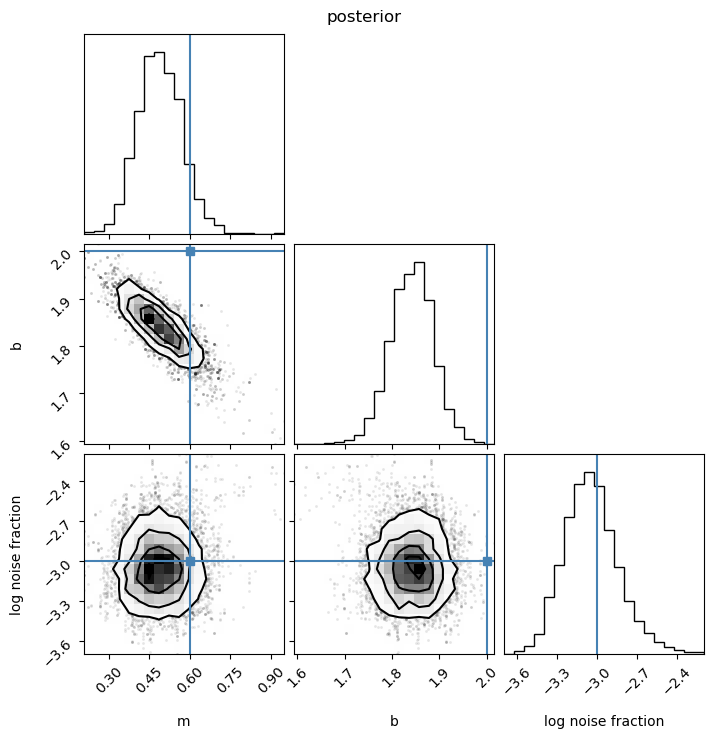

In [29]:
fig = corner.corner(
    np.hstack([walker2.model_sampler.chain, walker2.likelihood_samplers[0].chain]),
    labels=[p.name for p in my_model.params]
    + [walker2.likelihood_samplers[0].params[0].name],
    label="posterior",
    truths=[true_params["m"], true_params["b"], np.log(noise_fraction)],
)
fig.suptitle("posterior")

Text(0.5, 1.0, 'option 2: unknown statistical error, systematic ignored')

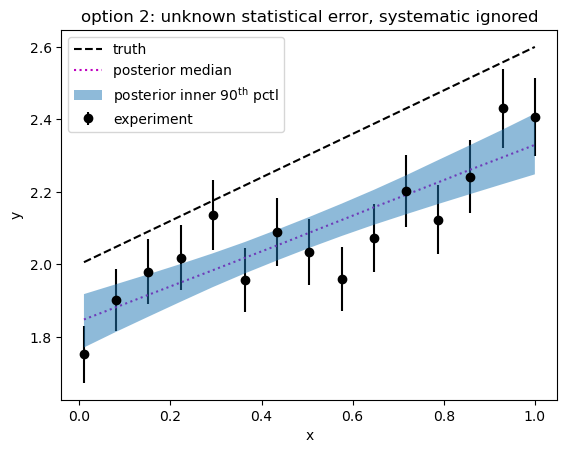

In [30]:
plot_predictive_post(
    walker=walker2, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 2: unknown statistical error, systematic ignored")

## Run option 3: correct formulation of the systematic error

In [31]:
walker3 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_sys_correct,
    rng=rng,
)

In [32]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.750
CPU times: user 3.25 s, sys: 44.4 ms, total: 3.29 s
Wall time: 3.24 s


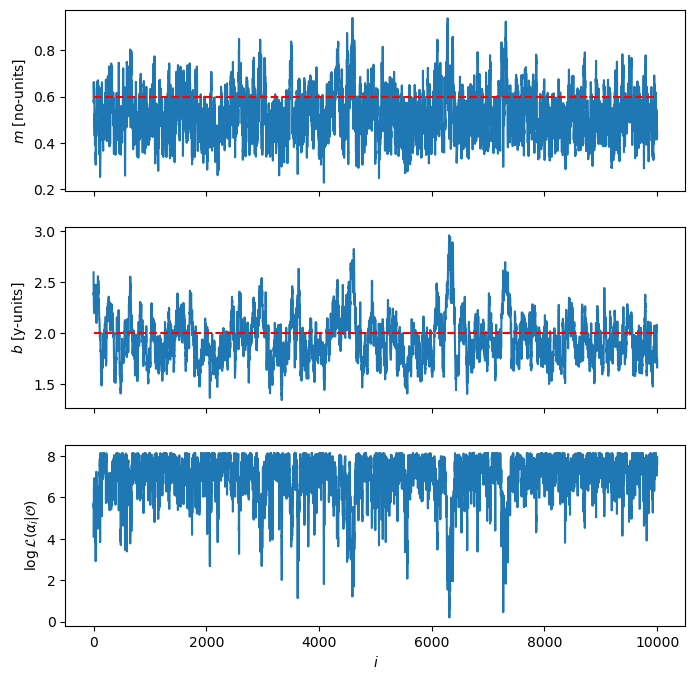

In [33]:
plot_chains(walker=walker3, model=my_model, true_params=true_params)

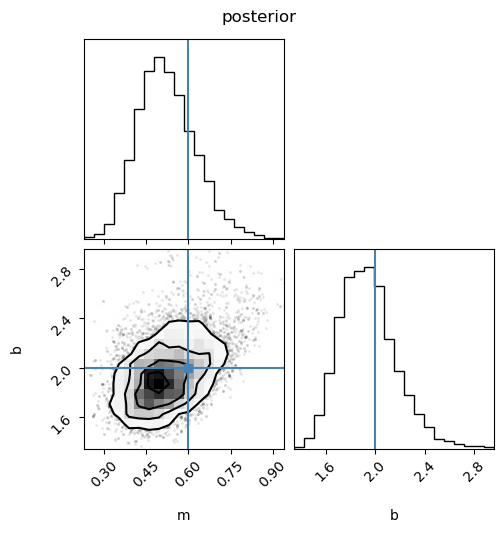

In [34]:
plot_posterior_corner(walker=walker3, true_params=true_params)

Text(0.5, 1.0, 'option 3: systematic included correctly')

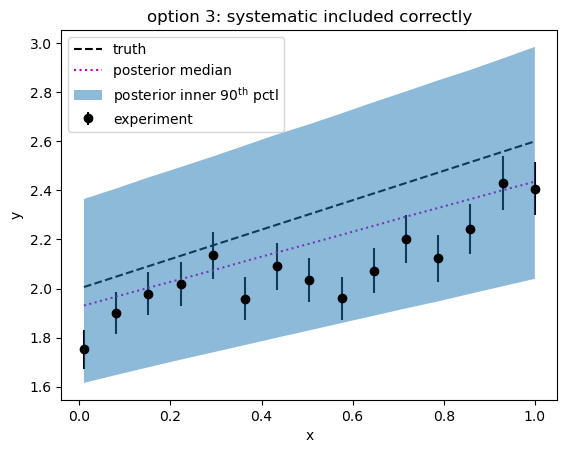

In [35]:
plot_predictive_post(
    walker=walker3, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 3: systematic included correctly")

## Run option 4: incorrect formulation of the systematic error

In [36]:
walker4 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_sys_wrong,
    rng=rng,
)

In [37]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.733
CPU times: user 2.47 s, sys: 15.2 ms, total: 2.49 s
Wall time: 2.46 s


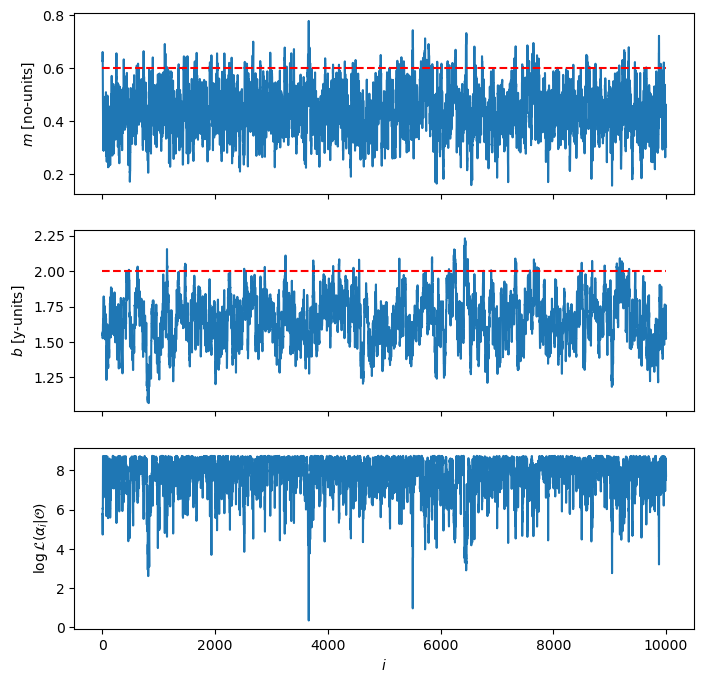

In [38]:
plot_chains(walker=walker4, model=my_model, true_params=true_params)

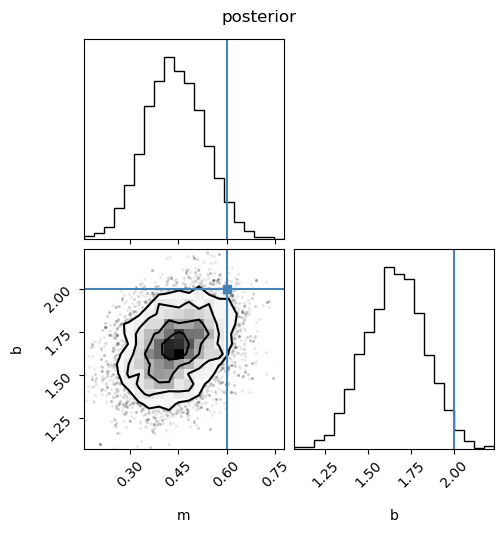

In [39]:
plot_posterior_corner(walker=walker4, true_params=true_params)

Text(0.5, 1.0, 'option 4: systematic included incorrectly')

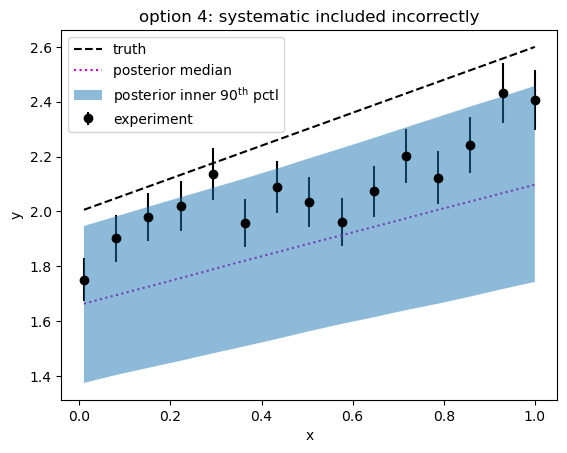

In [40]:
plot_predictive_post(
    walker=walker4, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 4: systematic included incorrectly")

# Multiple constraints
Let's choose a second constraint, with the same normalization bias in the opposite direction and the same coverage over the $x$-domain.

In [41]:
systematic_fractional_err2 = 0.1
# choose a normalization 1 std deviation above the mean this time
N2 = 1 + systematic_fractional_err2
noise_fraction2 = 0.025
x2 = np.linspace(0.01, 0.8, 27, dtype=float)
y_true2 = my_model.y(x2, *list(true_params.values()))
y_exp2 = (y_true2 + rng.normal(scale=noise_fraction2 * y_true2, size=len(x2))) * N2
y_stat_err2 = noise_fraction2 * y_exp2 * N2

In [42]:
x_full = np.linspace(-1, 2, 100)
y_true_full = my_model.y(x_full, *list(true_params.values()))

Text(0.5, 1.0, 'multiple experimental constraint with opposite bias')

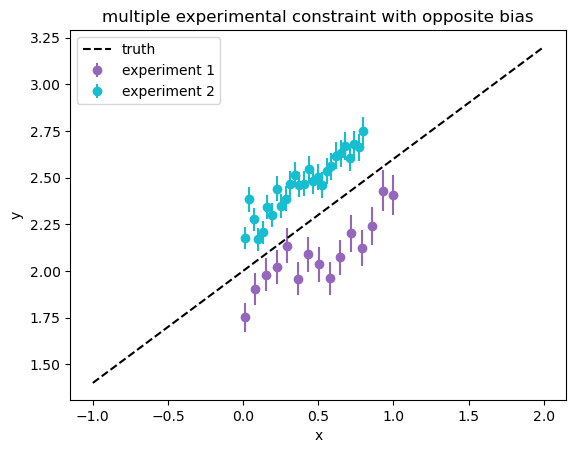

In [43]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker="o",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker="o",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
)

plt.plot(x_full, y_true_full, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple experimental constraint with opposite bias")

In [44]:
# 1 and 2
obs_stat_only2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
)

# 3
obs_sys_norm_correct2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
    y_sys_err_normalization=systematic_fractional_err2,
)

# 4
obs_sys_norm_wrong2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2)
    + systematic_fractional_err2**2 * np.outer(y_exp2, y_exp2),
)

## set up likelihood models and constraints

In [45]:
# 1
evidence_stat_only = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood,
        )
    ]
)

# 2
evidence_unknown_stat = rxmc.evidence.Evidence(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
evidence_sys_correct = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct, obs_sys_norm_correct2],
            my_model,
            likelihood,
        )
    ]
)

# 4
evidence_sys_wrong = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong, obs_sys_norm_wrong2],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [46]:
walker1 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_stat_only,
    rng=rng,
)

In [47]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.151
CPU times: user 3.75 s, sys: 0 ns, total: 3.75 s
Wall time: 3.75 s


In [48]:
upper1, med1, lower1 = np.percentile(
    [my_model.y(x_full, *p) for p in walker1.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

In [49]:
walker2 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_unknown_stat,
    likelihood_samplers=[
        rxmc.param_sampling.MetropolisHastingsSampler(
            params=likelihood_unknown_stat.params,
            starting_location=noise_prior.mean(),
            proposal=proposal_distribution_noise,
            prior=noise_prior,
        )
    ],
    rng=rng,
)

In [50]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.490
  Likelihood parameter acceptance fractions: [0.72]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.390
  Likelihood parameter acceptance fractions: [0.73]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.460
  Likelihood parameter acceptance fractions: [0.67]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.440
  Likelihood parameter acceptance fractions: [0.77]
Batch: 5/100 completed, 100 steps. 
  Model parameter acc

In [51]:
upper2, med2, lower2 = np.percentile(
    [my_model.y(x_full, *p) for p in walker2.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

In [52]:
walker3 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_sys_correct,
    rng=rng,
)

In [53]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.590
CPU times: user 4.33 s, sys: 1.9 ms, total: 4.33 s
Wall time: 4.33 s


In [54]:
upper3, med3, lower3 = np.percentile(
    [my_model.y(x_full, *p) for p in walker3.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

In [55]:
walker4 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_sys_wrong,
    rng=rng,
)

In [56]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.578
CPU times: user 2.51 s, sys: 3.99 ms, total: 2.51 s
Wall time: 2.51 s


In [57]:
upper4, med4, lower4 = np.percentile(
    [my_model.y(x_full, *p) for p in walker4.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

Text(0.5, 1.0, 'multiple constraints with systematic normalization error')

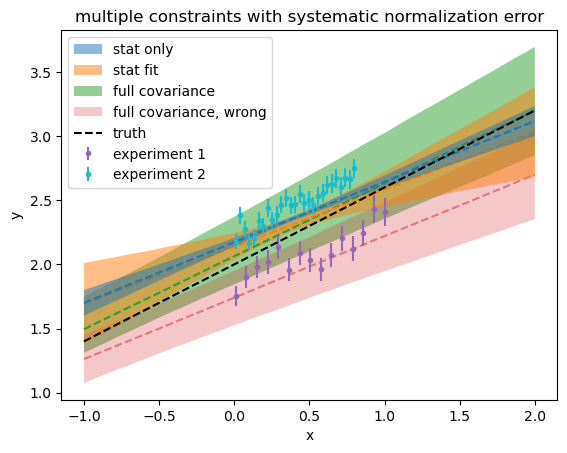

In [58]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker=".",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
    zorder=999,
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker=".",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
    zorder=999,
)
p = plt.fill_between(x_full, lower1, upper1, label="stat only", alpha=0.5, zorder=99)
plt.plot(x_full, med1, "--", color=p.get_facecolor(), alpha=1, zorder=100)


p = plt.fill_between(x_full, lower2, upper2, label="stat fit", alpha=0.5, zorder=89)
plt.plot(x_full, med2, "--", color=p.get_facecolor(), alpha=1, zorder=90)


p = plt.fill_between(x_full, lower3, upper3, label="full covariance", alpha=0.5)
plt.plot(x_full, med3, "--", color=p.get_facecolor(), alpha=1, zorder=89)

p = plt.fill_between(x_full, lower4, upper4, label="full covariance, wrong", alpha=0.25)
plt.plot(x_full, med4, "--", color=p.get_facecolor(), alpha=0.5)


plt.plot(x_full, y_true_full, "k--", label="truth", zorder=999)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple constraints with systematic normalization error")

# Multiple constraints with offset domain
Let's choose a second constraint, with the same normalization bias in the opposite direction and slightly different coverage opver $x$.

In [59]:
x2 = np.linspace(0.6, 1.4, 27, dtype=float)
y_true2 = my_model.y(x2, *list(true_params.values()))
y_exp2 = (y_true2 + rng.normal(scale=noise_fraction2 * y_true2, size=len(x2))) * N2
y_stat_err2 = noise_fraction2 * y_exp2 * N2

Text(0.5, 1.0, '$x$-offset experimental constraint with opposite bias')

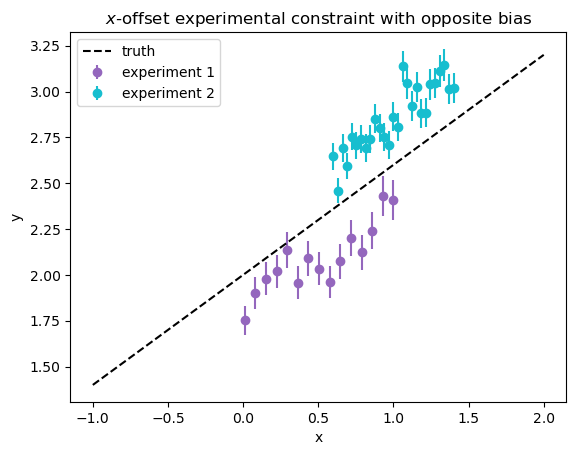

In [60]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker="o",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker="o",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
)

plt.plot(x_full, y_true_full, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("$x$-offset experimental constraint with opposite bias")

In [61]:
# 1 and 2
obs_stat_only2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
)

# 3
obs_sys_norm_correct2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
    y_sys_err_normalization=systematic_fractional_err2,
)

# 4
obs_sys_norm_wrong2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2)
    + systematic_fractional_err2**2 * np.outer(y_exp2, y_exp2),
)

## set up likelihood models and constraints

In [62]:
# 1
evidence_stat_only = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood,
        )
    ]
)

# 2
evidence_unknown_stat = rxmc.evidence.Evidence(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
evidence_sys_correct = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct, obs_sys_norm_correct2],
            my_model,
            likelihood,
        )
    ]
)

# 4
evidence_sys_wrong = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong, obs_sys_norm_wrong2],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [63]:
walker1 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_stat_only,
    rng=rng,
)

In [64]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.144
CPU times: user 4.77 s, sys: 4.92 ms, total: 4.77 s
Wall time: 4.77 s


In [65]:
upper1, med1, lower1 = np.percentile(
    [my_model.y(x_full, *p) for p in walker1.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

In [66]:
walker2 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_unknown_stat,
    likelihood_samplers=[
        rxmc.param_sampling.MetropolisHastingsSampler(
            params=likelihood_unknown_stat.params,
            starting_location=noise_prior.mean(),
            proposal=proposal_distribution_noise,
            prior=noise_prior,
        )
    ],
    rng=rng,
)

In [67]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.390
  Likelihood parameter acceptance fractions: [0.72]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.230
  Likelihood parameter acceptance fractions: [0.68]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.350
  Likelihood parameter acceptance fractions: [0.73]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.550
  Likelihood parameter acceptance fractions: [0.78]
Batch: 5/100 completed, 100 steps. 
  Model parameter acc

In [68]:
upper2, med2, lower2 = np.percentile(
    [my_model.y(x_full, *p) for p in walker2.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

In [69]:
walker3 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_sys_correct,
    rng=rng,
)

In [70]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.626
CPU times: user 4.97 s, sys: 4.93 ms, total: 4.98 s
Wall time: 4.99 s


In [71]:
upper3, med3, lower3 = np.percentile(
    [my_model.y(x_full, *p) for p in walker3.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

In [72]:
walker4 = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.MetropolisHastingsSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        proposal=proposal_distribution_model,
        prior=prior_distribution,
    ),
    evidence=evidence_sys_wrong,
    rng=rng,
)

In [73]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.618
CPU times: user 2.73 s, sys: 12.1 ms, total: 2.74 s
Wall time: 2.73 s


In [74]:
upper4, med4, lower4 = np.percentile(
    [my_model.y(x_full, *p) for p in walker4.model_sampler.chain],
    [5, 50, 95],
    axis=0,
)

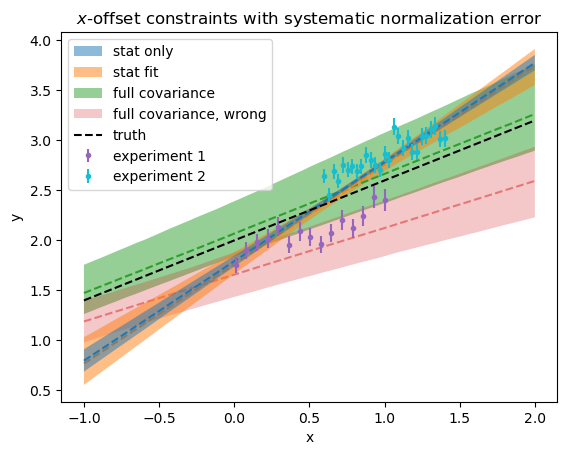

In [76]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker=".",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
    zorder=999,
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker=".",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
    zorder=999,
)
p = plt.fill_between(x_full, lower1, upper1, label="stat only", alpha=0.5, zorder=99)
plt.plot(x_full, med1, "--", color=p.get_facecolor(), alpha=1, zorder=100)


p = plt.fill_between(x_full, lower2, upper2, label="stat fit", alpha=0.5, zorder=89)
plt.plot(x_full, med2, "--", color=p.get_facecolor(), alpha=1, zorder=90)


p = plt.fill_between(x_full, lower3, upper3, label="full covariance", alpha=0.5)
plt.plot(x_full, med3, "--", color=p.get_facecolor(), alpha=1, zorder=89)

p = plt.fill_between(x_full, lower4, upper4, label="full covariance, wrong", alpha=0.25)
plt.plot(x_full, med4, "--", color=p.get_facecolor(), alpha=0.5)


plt.plot(x_full, y_true_full, "k--", label="truth", zorder=999)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("$x$-offset constraints with systematic normalization error")
plt.savefig("systematic_err.pdf")